In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
img_height, img_width = 32, 32
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/datasetfix/DATASETv7/TRAIN",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/datasetfix/DATASETv7/VALIDATION",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/datasetfix/DATASETv7/TEST",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 864 files belonging to 15 classes.
Found 214 files belonging to 15 classes.
Found 362 files belonging to 15 classes.


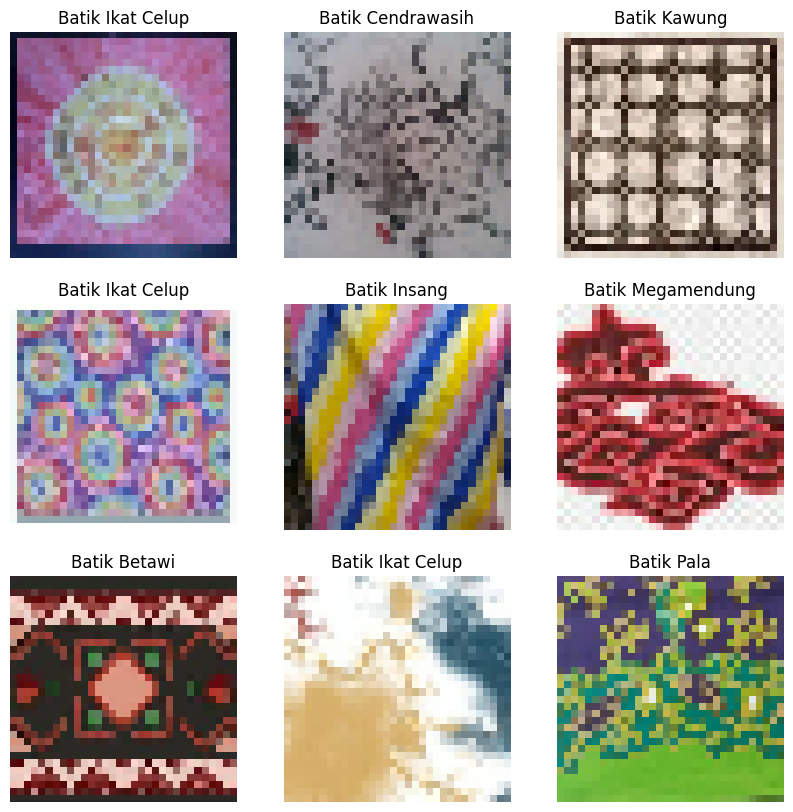

In [17]:
class_names = ["Batik Bali", "Batik Betawi", "Batik Cendrawasih", "Batik Dayak",
               "Batik Geblek Renteng", "Batik Ikat Celup",
               "Batik Insang", "Batik Kawung", "Batik Lasem",
               "Batik Megamendung", "Batik Pala", "Batik Parang",
               "Batik Poleng", "Batik Sekar Jagad", "Batik Tambal"]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
num_classes = 15

In [19]:
from tensorflow.keras.optimizers import Adam


model = models.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(64, 3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])



In [20]:
# Callback untuk menyimpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)

# Callback untuk menghentikan pelatihan jika val_accuracy tidak meningkat setelah beberapa epoch
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, mode="max", verbose=1)

# Callback untuk menghentikan pelatihan jika accuracy dan val_accuracy > 80% dan loss pada data pelatihan < 0.1
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        loss = logs.get('loss')

        if accuracy > 0.8 and val_accuracy > 0.8 and loss < 0.1:
            print(f"\nAccuracy dan val_accuracy mencapai target (>80%) dan loss pada data pelatihan < 0.1. Menghentikan pelatihan.")
            self.model.stop_training = True

In [21]:
# Gunakan learning rate yang lebih rendah
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [22]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=100,
    callbacks=[checkpoint, early_stopping, MyCustomCallback()]
)

Epoch 1/100
24/27 [=========================>....] - ETA: 0s - loss: 3.3874 - accuracy: 0.0820
Epoch 1: val_accuracy improved from -inf to 0.07182, saving model to best_model.h5
27/27 [==============================] - 7s 112ms/step - loss: 3.3975 - accuracy: 0.0856 - val_loss: 2.7148 - val_accuracy: 0.0718
Epoch 2/100
21/27 [======================>.......] - ETA: 0s - loss: 3.1686 - accuracy: 0.1042
Epoch 2: val_accuracy did not improve from 0.07182
27/27 [==============================] - 2s 50ms/step - loss: 3.1437 - accuracy: 0.1100 - val_loss: 2.7447 - val_accuracy: 0.0635
Epoch 3/100
26/27 [===========================>..] - ETA: 0s - loss: 2.9888 - accuracy: 0.1418
Epoch 3: val_accuracy did not improve from 0.07182
27/27 [==============================] - 2s 55ms/step - loss: 2.9847 - accuracy: 0.1424 - val_loss: 2.7804 - val_accuracy: 0.0552
Epoch 4/100
25/27 [==========================>...] - ETA: 0s - loss: 2.8385 - accuracy: 0.1475
Epoch 4: val_accuracy did not improve from 0

In [23]:
model.evaluate(test_ds)

12/12 [==============================] - 1s 12ms/step - loss: 0.9064 - accuracy: 0.7127


[0.9064232707023621, 0.7127071619033813]

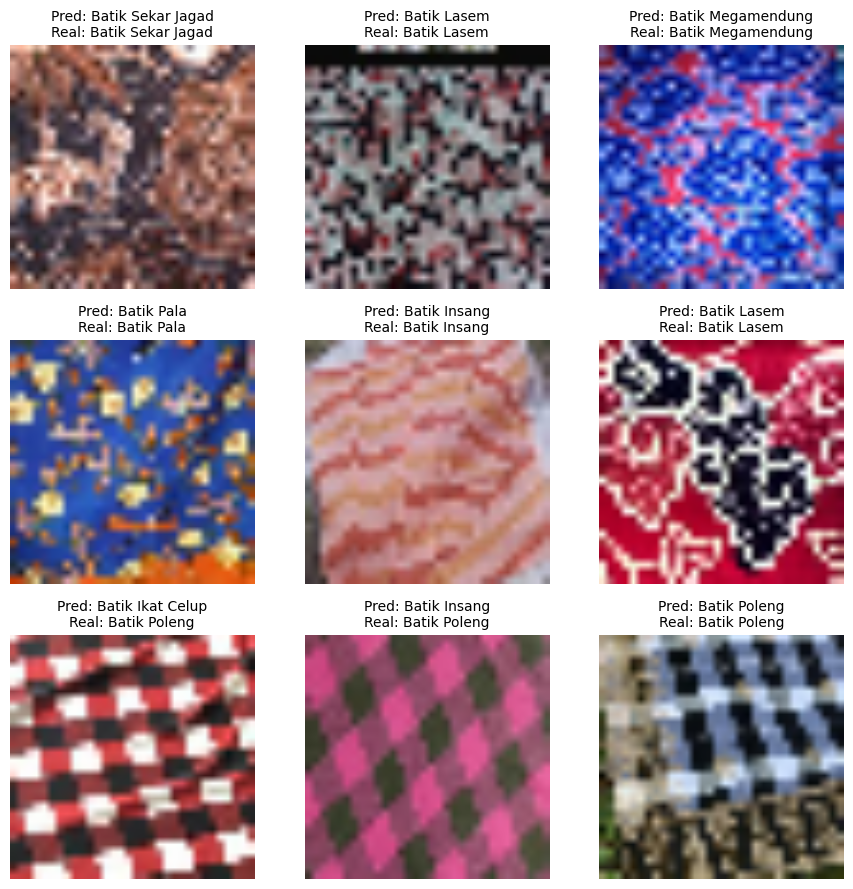

In [25]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))

for images, labels in test_ds.take(1):
    classifications = model(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), interpolation='bilinear')  # Adjust interpolation for image size
        index = np.argmax(classifications[i])
        title = "Pred: {}\nReal: {}".format(class_names[index], class_names[labels[i]])
        plt.title(title, fontsize=10)
        plt.axis('off')  # Turn off axis to improve spacing

plt.tight_layout()
plt.show()


In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)